In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Define file paths for training, testing, and validation CSV files
test_path = '/content/drive/MyDrive/DL/test_data.csv'
train_path = '/content/drive/MyDrive/DL/train_data.csv'
valid_path = '/content/drive/MyDrive/DL/valid_data.csv'


In [5]:
# Load CSV files into DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
valid_df = pd.read_csv(valid_path)

In [6]:
# Display tail of the training DataFrame
train_df.tail()

# Define fractions for train-test split
fractions = np.array([0.8, 0.1, 0.1])

# Shuffle the training data
train_df = train_df.sample(frac=1)

# Split the data into train, validation, and test sets
train_set, temp_set = train_test_split(train_df, test_size=fractions[1], random_state=42)
valid_set, test_set = train_test_split(temp_set, test_size=fractions[2], random_state=42)

In [7]:
# Display lengths of the datasets
print("Training set length:", len(train_set))
print("Validation set length:", len(valid_set))
print("Test set length:", len(test_set))

# Display unique labels in the dataset
train_df.label.unique()


Training set length: 7210
Validation set length: 721
Test set length: 81


array([4, 2, 6, 1, 0, 5, 3])

In [8]:
# Define classes
classes = {
    0: ('akiec', 'actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma'),
}


In [9]:
# Extract features and labels for training set
y_train = train_set['label']
x_train = train_set.drop(columns=['label'])

# Extract features and labels for validation set
y_valid = valid_set['label']
x_valid = valid_set.drop(columns=['label'])

# Extract features and labels for test set
y_test = test_set['label']
x_test = test_set.drop(columns=['label'])

# Convert x_train, x_valid, and x_test to NumPy arrays
x_train = np.array(x_train, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_valid = np.array(x_valid, dtype=np.uint8).reshape(-1, 28, 28, 3)
x_test = np.array(x_test, dtype=np.uint8).reshape(-1, 28, 28, 3)

# Reshape x_train to 2D array
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)

In [10]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Resample the training set using SMOTE to address class imbalance
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, y_train)


# Reshape x_train_resampled back to 4D array
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 28, 28, 3)

In [11]:
# Create a convolutional neural network model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

In [15]:
# Define model callbacks
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_smote.h5',
                                              monitor='val_accuracy', mode='max',
                                              verbose=1, save_best_only=True)

In [13]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_valid, y_valid),
                    batch_size=128,
                    epochs=50,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/50
266/266 [==============================] - ETA: 0s - loss: 1.7266 - accuracy: 0.3089
Epoch 1: val_accuracy improved from -inf to 0.64632, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_smote.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


266/266 [==============================] - 4s 16ms/step - loss: 1.7266 - accuracy: 0.3089 - val_loss: 1.6347 - val_accuracy: 0.6463
Epoch 2/50
264/266 [============================>.] - ETA: 0s - loss: 1.5708 - accuracy: 0.3566
Epoch 2: val_accuracy improved from 0.64632 to 0.68655, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_smote.h5
266/266 [==============================] - 3s 10ms/step - loss: 1.5703 - accuracy: 0.3569 - val_loss: 0.8394 - val_accuracy: 0.6865
Epoch 3/50
263/266 [============================>.] - ETA: 0s - loss: 1.4037 - accuracy: 0.4264
Epoch 3: val_accuracy did not improve from 0.68655
266/266 [==============================] - 3s 10ms/step - loss: 1.4030 - accuracy: 0.4268 - val_loss: 0.9310 - val_accuracy: 0.6560
Epoch 4/50
266/266 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.4923
Epoch 4: val_accuracy improved from 0.68655 to 0.71429, saving model to /content/drive/MyDrive/Colab Notebooks/Skin Cancer

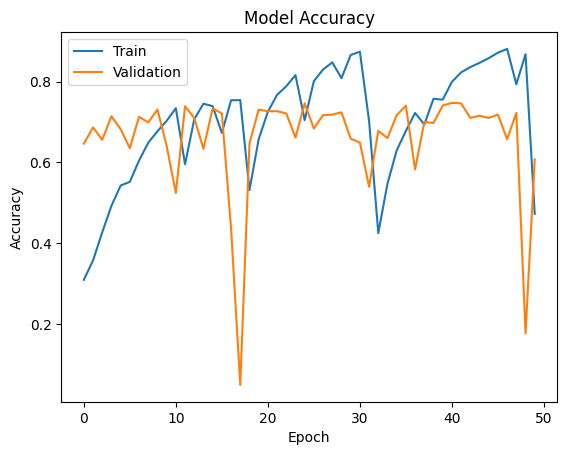

In [17]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Load the best model weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Skin Cancer/best_model_smote.h5')

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

3/3 - 0s - loss: 0.9918 - accuracy: 0.7160 - 269ms/epoch - 90ms/step
Test Loss: 0.9918
Test Accuracy: 0.7160


In [ ]:
# Make predictions on a sample image
image = PIL.Image.open('/content/drive/MyDrive/Skin-Cancer-Classification/1234214.jpg')
image = image.resize((28, 28))
img = np.array(image).reshape(-1, 28, 28, 3)


FileNotFoundError: ignored

In [ ]:
# Make predictions
result = model.predict(img)
print(result[0])

# Convert predictions to a class index
result = result.argmax(axis=-1)[0]

# Print the predicted class
print(classes[result])

In [20]:
# Generate confusion matrix and classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


3/3 [==============================] - 0s 5ms/step
Confusion Matrix:
[[ 1  1  2  1  0  0]
 [ 0  3  1  0  0  0]
 [ 0  0  3  5  0  1]
 [ 0  0  1 51  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  3  7  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.75      0.75      0.75         4
           2       0.30      0.33      0.32         9
           4       0.78      0.98      0.87        52
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10

    accuracy                           0.72        81
   macro avg       0.47      0.38      0.38        81
weighted avg       0.64      0.72      0.65        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
